# 2-Level 6-Factor Full Factorial (With 30 replicates)
# (TESTCASE B)
# Analizing Data

<br />

### Table of Contents
* [Preliminaries](#Preliminaries)
 * Importing Python Package
 * [Reading DOE data and encoded values](#ReadingDOE)
* [DOE Analysis](#DOEAnalysis)
 * [Defining variables and variable labels](#DOEVariables)
 * [Computing Main and Interaction Effects](#DOEEffects)
  * [Constant Effect](#DOEConstantEffect)
  * [Interaction effects (2-variable to 6-variable interactions)](#DOEInteractionEffect)
 * [Analysis of results](#DOE_An)
  * [Analyzing Effects](#DOE_An_eff)
  * [Main effects plot](#DOE_An_MEffPl)
  * [Interaction effects plot](#DOE_An_IEffPl)
  * [Quantile-Quantile Effects Plot](#DOE_An_QEffPl)

### TODO
* Analysis of results:
 * [Utilizing Degrees of Freedom](#dof)
 * [Ordinary Least Squares Regression Model](#ols)
 * [Goodness of Fit](#goodness_of_fit)
 * [Distribution of Error](#distribution_of_error)
 * [Aggregating Results](#aggregating)
 * [Distribution of Variance](#dist_variance)
 * [Residual vs. Response Plots](#residual)

<br />

# Preliminaries <a name="Preliminaries"></a>
## Importing packages

In [1]:
import numpy as np
import pandas as pd
import itertools as it

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

from thesis_EAfunc import *
from thesis_visfunc import *

In [2]:
import datetime
time_a = datetime.datetime.now()
print(time_a)

2019-05-24 11:01:32.783874


## Reading DOE data and encoded values  <a name="ReadingDOE"></a>

In [3]:
doe = pd.read_pickle('./EA_B_05_data.gz', compression='gzip')
coded_values = pd.read_pickle('./EA_B_05_code.gz', compression='gzip')
coded_values

,Label,Variable type,Value_low,Value_high,encoded_low,encoded_high
index,,,,,,
pop_s,Population size,Numerical,10,30,-1,1
b,Progeny-to-population ratio,Numerical,0.5,5,-1,1
mut_p,Mutation Probability,Numerical (<1),0.1,0.9,-1,1
mut_s,Mutation size,Numerical,0.1,10,-1,1
p_sel,Parent selection,Categorical,fitness proportional,tournament k3,-1,1
s_sel,Survivor selection method,Categorical,fitness proportional,tournament k3,-1,1


In [4]:
doe.head()

,pop_s,b,mut_p,mut_s,p_sel,s_sel,f_min,f_max,f_mean,f_std
run,,,,,,,,,,
0,-1,-1.0,-1.0,-1.0,-1,-1,5.143290,5.143290,5.143290,0.000000
1,-1,-1.0,-1.0,-1.0,-1,-1,42.836483,42.959203,42.898512,0.044530
2,-1,-1.0,-1.0,-1.0,-1,-1,45.071924,45.071924,45.071924,0.000000
3,-1,-1.0,-1.0,-1.0,-1,-1,0.024066,0.024066,0.024066,0.000000
4,-1,-1.0,-1.0,-1.0,-1,-1,17.900133,24.086404,18.518760,1.956271


In [5]:
list(doe.columns[0:6])

['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']

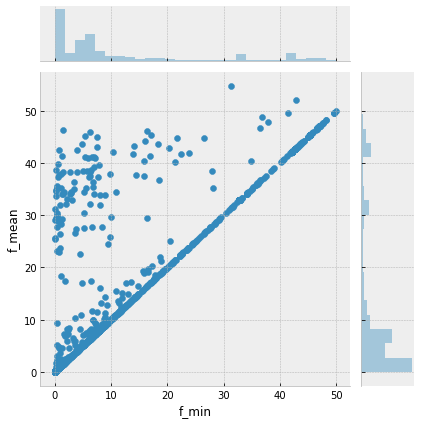

In [18]:
sns.jointplot(x="f_min", y="f_mean", data=doe)

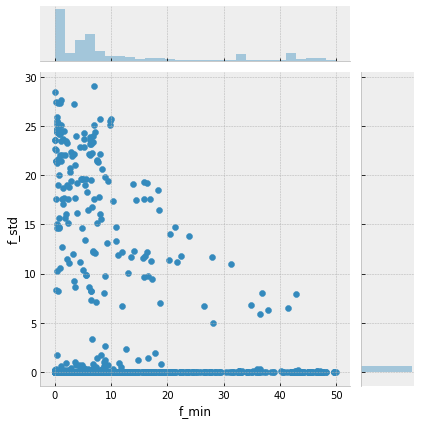

In [19]:
sns.jointplot(x="f_min", y="f_std", data=doe)

# DOE Analisis of Data  <a name="DOEAnalysis"></a>
## Defining variables and variable labels  <a name="DOEVariables"></a>

In [6]:
labels = {}
labels[1] = list(doe.columns[0:6])
for i in [2,3,4,5,6]:
    labels[i] = list(it.combinations(labels[1], i))

obs_list = list(doe.columns[-4:-1])

for k in labels.keys():
    print(str(k) + " : " + str(labels[k]))
print()
print(obs_list)

1 : ['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']
2 : [('pop_s', 'b'), ('pop_s', 'mut_p'), ('pop_s', 'mut_s'), ('pop_s', 'p_sel'), ('pop_s', 's_sel'), ('b', 'mut_p'), ('b', 'mut_s'), ('b', 'p_sel'), ('b', 's_sel'), ('mut_p', 'mut_s'), ('mut_p', 'p_sel'), ('mut_p', 's_sel'), ('mut_s', 'p_sel'), ('mut_s', 's_sel'), ('p_sel', 's_sel')]
3 : [('pop_s', 'b', 'mut_p'), ('pop_s', 'b', 'mut_s'), ('pop_s', 'b', 'p_sel'), ('pop_s', 'b', 's_sel'), ('pop_s', 'mut_p', 'mut_s'), ('pop_s', 'mut_p', 'p_sel'), ('pop_s', 'mut_p', 's_sel'), ('pop_s', 'mut_s', 'p_sel'), ('pop_s', 'mut_s', 's_sel'), ('pop_s', 'p_sel', 's_sel'), ('b', 'mut_p', 'mut_s'), ('b', 'mut_p', 'p_sel'), ('b', 'mut_p', 's_sel'), ('b', 'mut_s', 'p_sel'), ('b', 'mut_s', 's_sel'), ('b', 'p_sel', 's_sel'), ('mut_p', 'mut_s', 'p_sel'), ('mut_p', 'mut_s', 's_sel'), ('mut_p', 'p_sel', 's_sel'), ('mut_s', 'p_sel', 's_sel')]
4 : [('pop_s', 'b', 'mut_p', 'mut_s'), ('pop_s', 'b', 'mut_p', 'p_sel'), ('pop_s', 'b', 'mut_p', 's_sel'), ('pop_s'

## Computing Main and Interaction Effects <a name="DOEEffects"></a>
### Constant Effect <a name="DOEConstantEffect"></a>

In [7]:
effects = {}

# Start with the constant effect: this is $\overline{y}$
effects[0] = {'x0' : [doe['f_min'].mean(), doe['f_max'].mean(), doe['f_mean'].mean()]}
print(effects[0])

{'x0': [10.739391799288473, 15.63213071619944, 12.587895917406774]}


### Main effect of each variable <a name="DOEMainEffect"></a>

In [8]:
effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = doe.groupby(key)[obs].mean()
        result = sum([ zz*effects_df.loc[zz] for zz in effects_df.index ])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'pop_s': [-9.32252232903742, -7.523392157288555, -8.898676574717783],
 'b': [-5.170887919093902, -0.9114939957804804, -1.9449777132814177],
 'mut_p': [-4.4909717451271955, 4.978583382137442, -0.8976108919262433],
 'mut_s': [-4.114095511973309, 5.467256437766787, -0.47694858432516796],
 'p_sel': [-1.970786896520769, -2.0992555542182885, -1.978178022567846],
 's_sel': [1.9265126521441367, 11.395969399953993, 5.601596975849882]}

### Interaction effects (2-variable to 6-variable interactions) <a name="DOEInteractionEffect"></a>

In [9]:
for c in [2,3,4,5,6]:
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby(key)[obs].mean()
            result = sum([ np.prod(zz)*effects_df.loc[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
            effects_result.append(result)
        effects[c][key] = effects_result

C:\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [10]:
def printd(d):
    for k in d.keys():
        print("%25s : %s"%(k,d[k]))

for i in range(1,7):
    printd(effects[i])

                    pop_s : [-9.32252232903742, -7.523392157288555, -8.898676574717783]
                        b : [-5.170887919093902, -0.9114939957804804, -1.9449777132814177]
                    mut_p : [-4.4909717451271955, 4.978583382137442, -0.8976108919262433]
                    mut_s : [-4.114095511973309, 5.467256437766787, -0.47694858432516796]
                    p_sel : [-1.970786896520769, -2.0992555542182885, -1.978178022567846]
                    s_sel : [1.9265126521441367, 11.395969399953993, 5.601596975849882]
           ('pop_s', 'b') : [1.3619576632011245, 1.1743875778787798, 1.8074049979544293]
       ('pop_s', 'mut_p') : [-0.017733000679635014, 1.889086194522207, 0.4428408267464965]
       ('pop_s', 'mut_s') : [3.927060768119898, 5.7300301937097, 4.368010806630682]
       ('pop_s', 'p_sel') : [1.0794930341902433, 2.07843716021637, 1.3515477448098174]
       ('pop_s', 's_sel') : [-0.4976673485908578, 1.095185235901198, -0.07643381228712975]
           ('b', 'mut

## Analysis of results <a name="DOE_An"></a>
### Analyzing Effects <a name="DOE_An_eff"></a>

In [11]:
print(len(effects))

7


In [12]:
master_dict = {}
for nvars in effects.keys():

    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = v

master_df = pd.DataFrame(master_dict).T
master_df.columns = obs_list
master_df.head()

,f_min,f_max,f_mean
x0,10.739392,15.632131,12.587896
pop_s,-9.322522,-7.523392,-8.898677
b,-5.170888,-0.911494,-1.944978
mut_p,-4.490972,4.978583,-0.897611
mut_s,-4.114096,5.467256,-0.476949


In [13]:
n=30
k= 6

y1 = master_df[['f_min']].copy()
y1 = y1.iloc[y1['f_min'].abs().argsort].iloc[::-1]
y1 = y1.drop('x0')
y1.columns = ['Effects_Estimate']
y1.index.names = ['Factors']
y1['Sum_of_Squares'] = y1['Effects_Estimate']**2 * n * (2**(k-2))

SS_tot = (doe['f_min']**2).sum() - ((doe['f_min'].sum()**2)/len(doe['f_min']))
SS_err = SS_tot - (y1['Sum_of_Squares'].sum())
y1['%_Contribution'] = y1['Sum_of_Squares']/SS_tot*100

print("Top 10 effects for observable 'minimum fitness:'")
print(y1[:10])
print()
print("Error: " + str(SS_err) + "     " + "Error (% Contribution): " + str(SS_err/SS_tot))

Top 10 effects for observable 'minimum fitness:'
                       Effects_Estimate  Sum_of_Squares  %_Contribution
Factors                                                                
pop_s                         -9.322522    41716.522836       11.657262
b                             -5.170888    12834.279298        3.586410
mut_p                         -4.490972     9681.037063        2.705268
mut_s                         -4.114096     8124.375303        2.270275
(pop_s, mut_s)                 3.927061     7402.467013        2.068545
(b, mut_p)                     3.692957     6546.208142        1.829272
(mut_p, mut_s)                -2.232056     2391.396503        0.668252
(mut_s, p_sel)                 2.225666     2377.723044        0.664431
(mut_p, mut_s, p_sel)          2.053946     2024.973734        0.565859
p_sel                         -1.970787     1864.320476        0.520966

Error: 243547.3650334897     Error (% Contribution): 0.6805685716550777


In [14]:
ANOVA_y1 = y1.copy()
ANOVA_y1 = ANOVA_y1.drop('Effects_Estimate',axis=1)
ANOVA_y1['Dgrs. Freedom'] = 1
df_tot = len(doe['f_min'])-1
df_err = df_tot - len(master_df)

ANOVA_y1['Mean Sqrs'] = ANOVA_y1['Sum_of_Squares']/1
ms_err = SS_err / df_err

ANOVA_y1['F ratio'] = ANOVA_y1['Mean Sqrs']/ms_err
sig_level=0.05
ANOVA_y1['F critical'] = stats.f.ppf(q=1-sig_level, dfn=1, dfd=df_tot)
ANOVA_y1['Significant'] = (ANOVA_y1['F ratio'] > ANOVA_y1['F critical'])

#ANOVA_y1.loc['Error'] = [SS_err] +[] + []
#ANOVA_y1.loc['Total'] = [SS_tot] + [] + []

df_show = ANOVA_y1.iloc[np.r_[0:10,-2:0]]
df_show

,Sum_of_Squares,%_Contribution,Dgrs. Freedom,Mean Sqrs,F ratio,F critical,Significant
Factors,,,,,,,
pop_s,41716.522836,11.657262,1,41716.522836,317.737578,3.846309,True
b,12834.279298,3.586410,1,12834.279298,97.753421,3.846309,True
mut_p,9681.037063,2.705268,1,9681.037063,73.736473,3.846309,True
mut_s,8124.375303,2.270275,1,8124.375303,61.880022,3.846309,True
"(pop_s, mut_s)",7402.467013,2.068545,1,7402.467013,56.381543,3.846309,True
"(b, mut_p)",6546.208142,1.829272,1,6546.208142,49.859772,3.846309,True
"(mut_p, mut_s)",2391.396503,0.668252,1,2391.396503,18.214283,3.846309,True
"(mut_s, p_sel)",2377.723044,0.664431,1,2377.723044,18.110137,3.846309,True
"(mut_p, mut_s, p_sel)",2024.973734,0.565859,1,2024.973734,15.423391,3.846309,True


### Main effects plot <a name="DOE_An_MEffPl"></a>

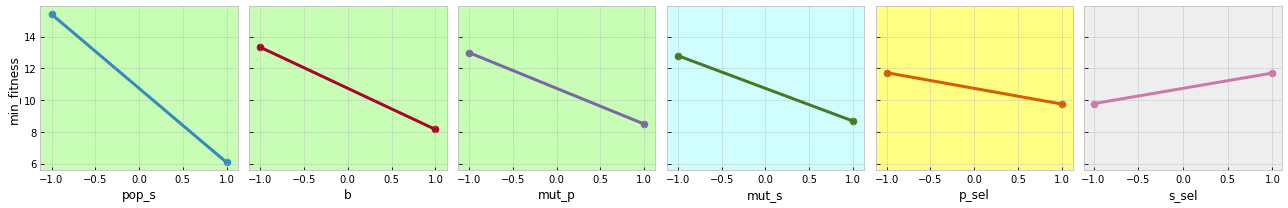

In [15]:
variable = ['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']
f, axs = plt.subplots(1, 6, figsize=(18,3), sharey=True)
x_ci=None
for i in range(len(variable)):
        sns.regplot(x=variable[i], y='f_min', data=doe, x_estimator=np.mean, x_ci=x_ci, ci=None, truncate=True, ax=axs[i])
for ax in axs.flat:
    ax.set_ylabel(None)
axs[0].set_ylabel('min_fitness')


axs[0].set_facecolor('xkcd:pale green')
axs[1].set_facecolor('xkcd:pale green')
axs[2].set_facecolor('xkcd:pale green')

axs[3].set_facecolor('xkcd:pale blue')

axs[4].set_facecolor('xkcd:pale yellow')

plt.tight_layout()

### Interaction effects plot <a name="DOE_An_IEffPl"></a>

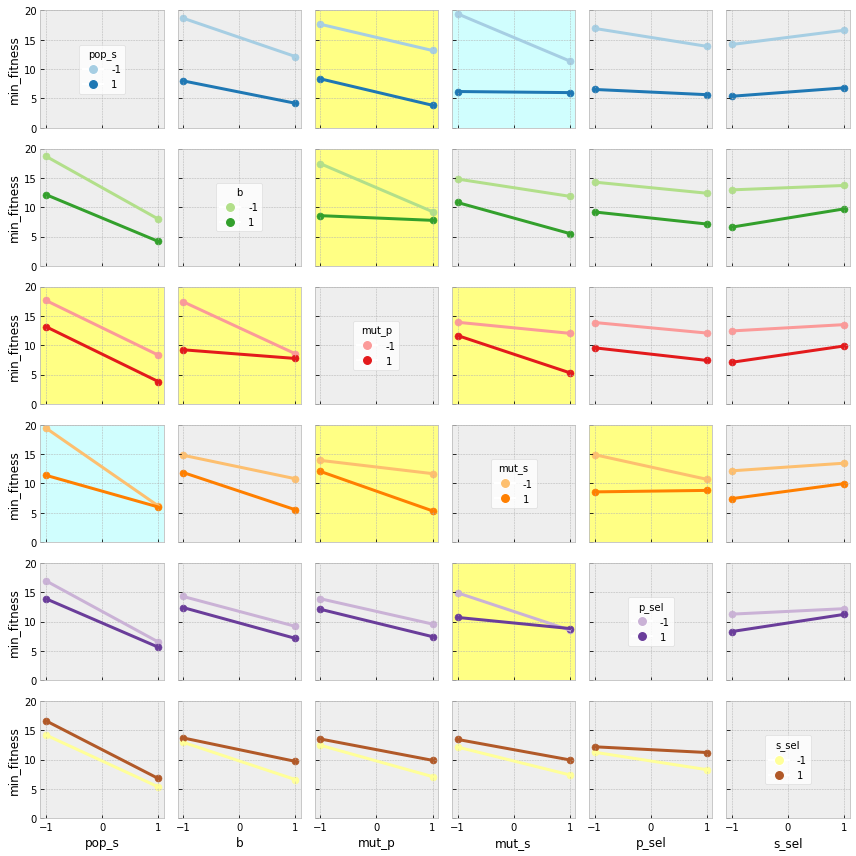

In [16]:
factors = ['pop_s', 'b', 'mut_p', 'mut_s', 'p_sel', 's_sel']
f, axs = plt.subplots(6, 6, figsize=(12, 12), sharey=True, sharex=True)
x_ci = None

# set palette 
palette = it.cycle(sns.color_palette("Paired"))

for i in range(len(factors)):
    for j in range(len(factors)):
        yy = factors[j]
        
        c = next(palette)
        sns.regplot(x=factors[i], y='f_min', data=doe[doe[yy]==-1], label='-1', x_estimator=np.mean, color=c, x_ci=x_ci, ci=None, truncate=True, ax=axs[j,i])
        c = next(palette)
        sns.regplot(x=factors[i], y='f_min', data=doe[doe[yy]==1], label='1', x_estimator=np.mean, color=c, x_ci=x_ci, ci=None, truncate=True, ax=axs[j,i])
        
        #axs[j,i].legend(title=yy,facecolor='white')

        if i==j:
            axs[j,i].clear()

for ax in axs.flat:
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
axs[0,0].set_xlim((-1.1, 1.1))
axs[0,0].set_ylim((0, 20))

from matplotlib.lines import Line2D

for i in range(len(factors)):
    axs[i,0].set_ylabel('min_fitness')
    axs[-1,i].set_xlabel(factors[i])
    legend_elements = [ Line2D([0], [0], marker='o', color='w', label=-1, markerfacecolor=next(palette), markersize=10),
                       Line2D([0], [0], marker='o', color='w', label=1, markerfacecolor=next(palette), markersize=10)]
    axs[i,i].legend(handles=legend_elements, loc='center', title=factors[i], facecolor='white')


axs[0,3].set_facecolor('xkcd:pale blue')
axs[3,0].set_facecolor('xkcd:pale blue')


axs[2,1].set_facecolor('xkcd:pale yellow')
axs[1,2].set_facecolor('xkcd:pale yellow')
axs[2,3].set_facecolor('xkcd:pale yellow')
axs[3,2].set_facecolor('xkcd:pale yellow')
axs[3,4].set_facecolor('xkcd:pale yellow')
axs[4,3].set_facecolor('xkcd:pale yellow')
axs[0,2].set_facecolor('xkcd:pale yellow')
axs[2,0].set_facecolor('xkcd:pale yellow')

    
plt.tight_layout()
plt.show()

### Quantile-Quantile Effects Plot <a name="DOE_An_QEffPl"></a>

Text(0.5, 1.0, 'y1')

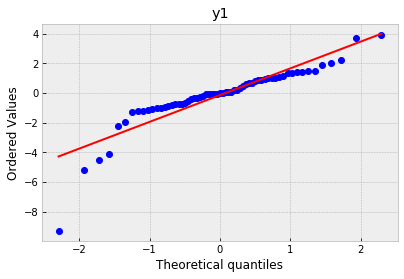

In [17]:
# Quantify which effects are not normally distributed, 
# to assist in identifying important variables

fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)

stats.probplot(y1['Effects_Estimate'], dist="norm", plot=ax1)
ax1.set_title('y1')

In [16]:
time_c = datetime.datetime.now()
print(time_c)
print(time_c-time_a)

2019-05-12 16:18:59.089603
0:17:18.365861
